In [3]:
import seaborn as sns
import json
import mmcv
from src.extensions.dataset.coco_custom import CocoOtcDataset
import os
import pandas as pd

imported!


In [2]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [5]:
MODEL_CFGS = {
    "retinanet_r50_fpn_2x_coco": "RetinaNet",
    "faster_rcnn_r50_fpn_2x_coco": "Faster-RCNN",
    "yolof_r50_c5_8x8_1x_coco": "YOLOF",
    "detr_r50_8x2_150e_coco": "DETR",
    "vfnet_r50_fpn_mstrain_2x_coco": "VFNet",
}

outputs/evaluate_bootstrap/20211005_182455/RetinaNet.measures.json
outputs/evaluate_bootstrap/20211005_182455/Faster-RCNN.measures.json
outputs/evaluate_bootstrap/20211005_182455/YOLOF.measures.json
outputs/evaluate_bootstrap/20211005_182455/DETR.measures.json
outputs/evaluate_bootstrap/20211005_182455/VFNet.measures.json


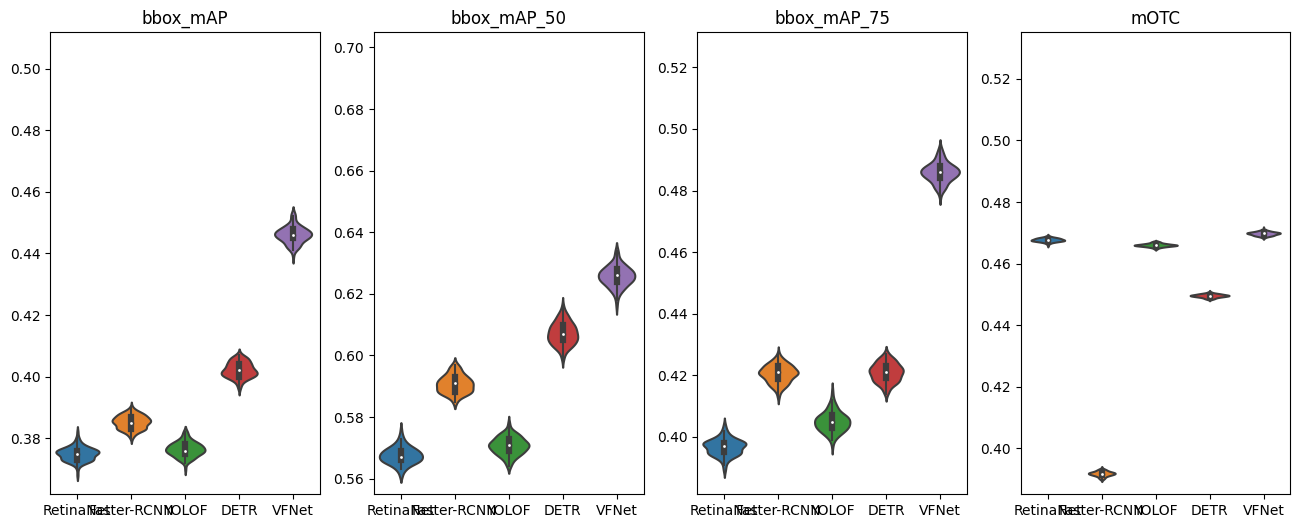

In [6]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns

out_dir = "outputs/evaluate_bootstrap/20211005_182455"
measures=["bbox_mAP", "bbox_mAP_50", "bbox_mAP_75", "mOTC"]
files = [os.path.join(out_dir, f"{v}.measures.json") for _, v in MODEL_CFGS.items()]
# files = glob.glob(os.path.join(out_dir, "*.measures.json"))
ncols = len(measures)

f, axes = plt.subplots(
    1, ncols, figsize=(4 * ncols, 6)
)

data_frame = {measure: [] for measure in measures}
data_frame["model"] = []

for file in files:
    print(file)
    data = json.load(open(file))
    model_name = os.path.basename(file).split(".")[0]
    data_frame["model"] += [model_name] * len(data)
    for measure in measures:
        data_frame[measure] += [x[measure] for x in data]

data_frame = pd.DataFrame(data_frame)
for i, measure in enumerate(measures):
    ax = axes[i]
    sns.violinplot(x="model", y=measure, ax=ax, data=data_frame)
    ax.set_title(measure)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min, y_min + 0.15)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

In [7]:
import numpy as np
pd.set_option('display.float_format','{:.5f}'.format)

measures_overall_file = os.path.join(out_dir, "overall.measures.json")
if os.path.exists(measures_overall_file):
    measures_overall = json.load(open(measures_overall_file))
else:
    measures_overall = get_overall_measures(out_dir)
    json.dump(measures_overall, open(measures_overall_file, "w"))


bias_table = []
for model_name in MODEL_CFGS.values():
    entry = []
    for measure in measures:
        all_score = measures_overall[model_name][measure]
        sub_mean = data_frame[data_frame.model == model_name][measure].mean()
        entry.append(f"{all_score:.4f}")
        entry.append(f"{sub_mean:.4f} ({sub_mean-all_score:.5f})")
    bias_table.append(entry)

columns = np.ravel([[measure, f"{measure} (80%)"] for measure in measures])
columns = columns.tolist()
table = pd.DataFrame(np.asarray(bias_table), columns=columns)
table["model"] = MODEL_CFGS.values()
table.set_index("model")



,bbox_mAP,bbox_mAP (80%),bbox_mAP_50,bbox_mAP_50 (80%),bbox_mAP_75,bbox_mAP_75 (80%),mOTC,mOTC (80%)
model,,,,,,,,
RetinaNet,0.3740,0.3749 (0.00094),0.5670,0.5675 (0.00054),0.3960,0.3967 (0.00072),0.4677,0.4677 (0.00000)
Faster-RCNN,0.3840,0.3852 (0.00124),0.5900,0.5907 (0.00072),0.4200,0.4205 (0.00054),0.3918,0.3918 (0.00000)
YOLOF,0.3750,0.3765 (0.00145),0.5700,0.5707 (0.00068),0.4040,0.4049 (0.00094),0.4661,0.4660 (-0.00004)
DETR,0.4010,0.4022 (0.00121),0.6060,0.6072 (0.00119),0.4200,0.4209 (0.00095),0.4496,0.4496 (0.00001)
VFNet,0.4450,0.4461 (0.00110),0.6250,0.6257 (0.00075),0.4850,0.4860 (0.00095),0.4698,0.4698 (0.00000)


In [12]:
from tabulate import tabulate
print(tabulate(table, headers="keys", tablefmt="psql"))

+----+------------+------------------+---------------+---------------------+---------------+---------------------+--------+-------------------+-------------+
|    |   bbox_mAP | bbox_mAP (80%)   |   bbox_mAP_50 | bbox_mAP_50 (80%)   |   bbox_mAP_75 | bbox_mAP_75 (80%)   |   mOTC | mOTC (80%)        | model       |
|----+------------+------------------+---------------+---------------------+---------------+---------------------+--------+-------------------+-------------|
|  0 |      0.374 | 0.3749 (0.00094) |         0.567 | 0.5675 (0.00054)    |         0.396 | 0.3967 (0.00072)    | 0.4677 | 0.4677 (0.00000)  | RetinaNet   |
|  1 |      0.384 | 0.3852 (0.00124) |         0.59  | 0.5907 (0.00072)    |         0.42  | 0.4205 (0.00054)    | 0.3918 | 0.3918 (0.00000)  | Faster-RCNN |
|  2 |      0.375 | 0.3765 (0.00145) |         0.57  | 0.5707 (0.00068)    |         0.404 | 0.4049 (0.00094)    | 0.4661 | 0.4660 (-0.00004) | YOLOF       |
|  3 |      0.401 | 0.4022 (0.00121) |         0.606

str